In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import wandb
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix

In [2]:
!pip install wandb -qU

In [3]:
path = kagglehub.dataset_download("uciml/student-alcohol-consumption")

print("Path to dataset files:", path)

files =os.listdir(path)
print("Files in dataset folder:", files)

csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)
print("Path to CSV file:", csv_path)

Path to dataset files: /root/.cache/kagglehub/datasets/uciml/student-alcohol-consumption/versions/2
Files in dataset folder: ['student-merge.R', 'student-por.csv', 'student-mat.csv']
Path to CSV file: /root/.cache/kagglehub/datasets/uciml/student-alcohol-consumption/versions/2/student-por.csv


In [4]:
my_dataframe = pd.read_csv(csv_path)
my_dataframe.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,6,12,12,13
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,13,12,13
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,2,10,13,13
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,15,16,17
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,12,12,13


In [5]:
my_dataframe = my_dataframe.drop(columns = ["school","famsize","Pstatus","Mjob","Fjob","reason","guardian","schoolsup","famsup","paid","activities","nursery","higher","internet","romantic"])

In [6]:
my_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sex         649 non-null    object
 1   age         649 non-null    int64 
 2   address     649 non-null    object
 3   Medu        649 non-null    int64 
 4   Fedu        649 non-null    int64 
 5   traveltime  649 non-null    int64 
 6   studytime   649 non-null    int64 
 7   failures    649 non-null    int64 
 8   famrel      649 non-null    int64 
 9   freetime    649 non-null    int64 
 10  goout       649 non-null    int64 
 11  Dalc        649 non-null    int64 
 12  Walc        649 non-null    int64 
 13  health      649 non-null    int64 
 14  absences    649 non-null    int64 
 15  G1          649 non-null    int64 
 16  G2          649 non-null    int64 
 17  G3          649 non-null    int64 
dtypes: int64(16), object(2)
memory usage: 91.4+ KB


In [7]:
our_sex_mapping = {
    'F': 0,
    'M': 1
}

In [8]:
my_dataframe['sex'] = my_dataframe['sex'].map(our_sex_mapping)

In [9]:
n = len(pd.unique(my_dataframe['address']))
unique_values = pd.unique(my_dataframe['address'])

print(n)
print(unique_values)

2
['U' 'R']


In [10]:
our_address_mapping = {
    'R': 0,
    'U': 1
}

In [11]:
my_dataframe['address'] = my_dataframe['address'].map(our_address_mapping)

In [12]:
my_dataframe.info
my_dataframe.head(10)

,sex,age,address,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,18,1,4,4,2,2,0,4,3,4,1,1,3,4,0,11,11
1,0,17,1,1,1,1,2,0,5,3,3,1,1,3,2,9,11,11
2,0,15,1,1,1,1,2,0,4,3,2,2,3,3,6,12,13,12
3,0,15,1,4,2,1,3,0,3,2,2,1,1,5,0,14,14,14
4,0,16,1,3,3,1,2,0,4,3,2,1,2,5,0,11,13,13
5,1,16,1,4,3,1,2,0,5,4,2,1,2,5,6,12,12,13
6,1,16,1,2,2,1,2,0,4,4,4,1,1,3,0,13,12,13
7,0,17,1,4,4,2,2,0,4,1,4,1,1,1,2,10,13,13
8,1,15,1,3,2,1,2,0,4,2,2,1,1,1,0,15,16,17
9,1,15,1,3,4,1,2,0,5,5,1,1,1,5,0,12,12,13


In [13]:
my_dataframe.describe()

,sex,age,address,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,0.409861,16.744222,0.696456,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,0.492187,1.218138,0.460143,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,0.000000,15.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,0.000000,17.000000,1.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,1.000000,18.000000,1.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,1.000000,22.000000,1.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [14]:
# Splitting features and target
y = my_dataframe["G3"]  # Final grade as target for regression
X = my_dataframe.drop(columns=["G3"])

In [15]:
desired_df = my_dataframe[['sex', 'address','G3']]
desired_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sex      649 non-null    int64
 1   address  649 non-null    int64
 2   G3       649 non-null    int64
dtypes: int64(3)
memory usage: 15.3 KB


In [16]:
feature_columns = ['sex', 'address']
label_column = ['G3']

# Extract features and label
features = desired_df[feature_columns].values
labels = desired_df[label_column].values

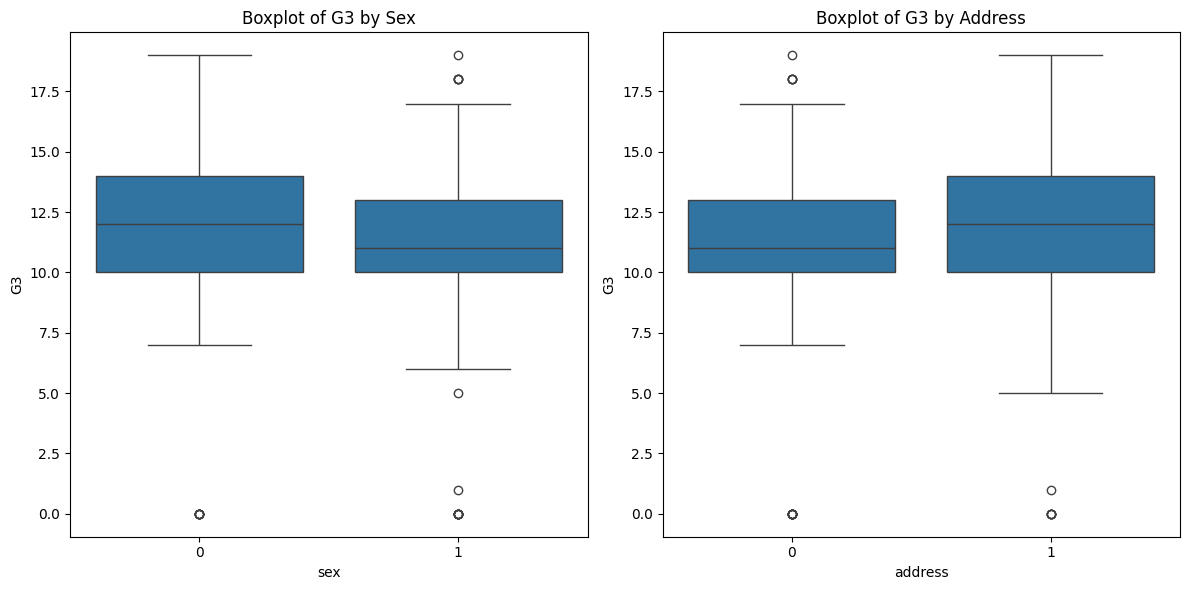

In [17]:
# Visualize 'G3' (final grade) across 'sex' and 'address'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='sex', y='G3', data=my_dataframe)
plt.title('Boxplot of G3 by Sex')

plt.subplot(1, 2, 2)
sns.boxplot(x='address', y='G3', data=my_dataframe)
plt.title('Boxplot of G3 by Address')

plt.tight_layout()
plt.show()

In [18]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

# Remove outliers for each feature
for feature in ['sex', 'address']:
    desired_df = remove_outliers(desired_df, feature)
    desired_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sex      649 non-null    int64
 1   address  649 non-null    int64
 2   G3       649 non-null    int64
dtypes: int64(3)
memory usage: 15.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sex      649 non-null    int64
 1   address  649 non-null    int64
 2   G3       649 non-null    int64
dtypes: int64(3)
memory usage: 15.3 KB


In [19]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(my_dataframe[feature_columns])

df_scaled = pd.DataFrame(scaled_data, columns=feature_columns)
df_scaled.head()

,sex,address
0,-0.833377,0.660182
1,-0.833377,0.660182
2,-0.833377,0.660182
3,-0.833377,0.660182
4,-0.833377,0.660182


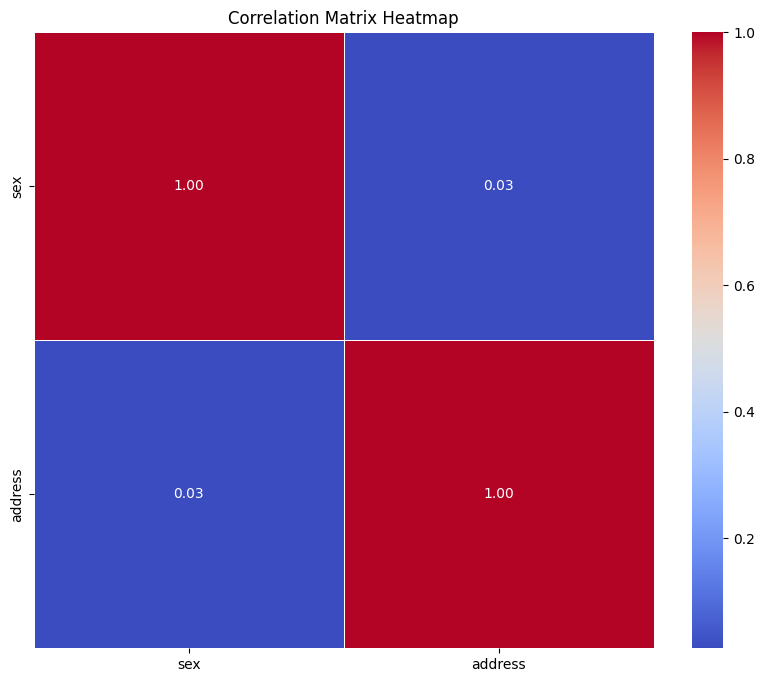

In [20]:
# Calculate correlation matrix
corr_matrix = df_scaled.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [21]:
# Split into train and temp (80% train, 20% temp)
train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Split temp into eval and test (50% of temp each, i.e., 10% each of original data)
eval_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Print the sizes of each subset
print("Train Data:")
print(train_data)
print("\nEval Data:") # 50% of the test subset
print(eval_data)
print("\nTest Data:") # 50% of the test subset
print(test_data)

Train Data:
          sex   address
332 -0.833377  0.660182
29   1.199937  0.660182
302  1.199937 -1.514733
286  1.199937 -1.514733
554 -0.833377 -1.514733
..        ...       ...
71   1.199937  0.660182
106 -0.833377  0.660182
270  1.199937  0.660182
435 -0.833377 -1.514733
102  1.199937  0.660182

[519 rows x 2 columns]

Eval Data:
          sex   address
131 -0.833377  0.660182
76   1.199937  0.660182
204 -0.833377  0.660182
133 -0.833377  0.660182
77  -0.833377  0.660182
..        ...       ...
403 -0.833377  0.660182
540 -0.833377  0.660182
463 -0.833377 -1.514733
41   1.199937  0.660182
24  -0.833377 -1.514733

[65 rows x 2 columns]

Test Data:
          sex   address
327 -0.833377 -1.514733
165 -0.833377 -1.514733
10  -0.833377  0.660182
55  -0.833377  0.660182
352  1.199937 -1.514733
..        ...       ...
209 -0.833377  0.660182
362 -0.833377  0.660182
514 -0.833377  0.660182
549 -0.833377 -1.514733
344  1.199937  0.660182

[65 rows x 2 columns]


In [22]:
# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [23]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_val_scaled = scaler.transform(X_val)

# Convert scaled data and labels to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_eval_tensor = torch.tensor(y_val, dtype=torch.float32)

#Model Initialization

In [24]:
# Define a PyTorch Neural Network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer=64, second_layer_neurons=32, num_classes=21, dropout_rate=0.2):
        super(NeuralNetwork, self).__init__()
        self.Linear1 = nn.Linear(input_size, hidden_layer)
        self.relu = nn.ReLU()
        self.Linear2 = nn.Linear(hidden_layer, second_layer_neurons)
        self.dropout = nn.Dropout(dropout_rate)
        self.Linear3 = nn.Linear(second_layer_neurons, num_classes)

    def forward(self, x):
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.Linear3(x)
        return x

In [39]:
criterion = nn.L1Loss()

In [40]:
def build_optimizer(network, optimizer_name, learning_rate):
    if optimizer_name == "sdg":
        optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    elif optimizer_name == "adam":
        optimizer = optim.AdamW(network.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}") # Handle unsupported optimizers

    return optimizer  # Return the optimizer object

In [41]:
def train_epoch(model, dataloader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()  # Zero the parameter gradients
        output = model(data)  # Forward pass
        # Assuming 'target' has labels 3 to 8, and needs to be shifted to 0 to 5
        target_shifted = target - 3
        # Squeeze target_shifted to make it 1D
        target_shifted = target_shifted.squeeze(1)
        loss = loss_fn(output, target_shifted)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader) # Return average epoch loss

In [42]:
# Define the model builder function
def build_model(hp):
  input_size = hp.input_size
  hidden_layer = hp.hidden_layer
  second_layer_neurons = hp.second_layer_neurons
  num_classes = hp.num_classes
  dropout_rate = hp.dropout_rate
  model = NeuralNetwork(input_size, hidden_layer, second_layer_neurons, num_classes, dropout_rate)
  return model

#Hyperparameter Tuning

In [43]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric
parameters_dict = {
    'optimizer': {
        'values': ['sdg', 'adam']
        },
    'input_size': {
        'values': [2]
        },
    'hidden_layer': {
        'values': [4, 8, 16, 32, 64]
        },
    'second_layer_neurons': {
        'values': [4, 8, 16, 32, 64]
        },
    'num_classes': {
        'values': [21]
        },
    'dropout_rate': {
        'values': [0.2, 0.3, 0.4, 0.5]
        }
    }
sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'distribution': 'int_uniform',
        'min': 500,
        'max': 1000
        }
    })
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.001
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 4 and 64
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 21,
        'min': 4,
        'max': 128,
      }
    })
# Start the sweep
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

Create sweep with ID: n4ff1982
Sweep URL: https://wandb.ai/sibusisongcana-cortex-hub/pytorch-sweeps-demo/sweeps/n4ff1982


In [44]:
def train():
    with wandb.init() as run:
        config = wandb.config

        # Build the model
        model = build_model(config)

        # Create DataLoaders
        training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        training_data_loader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=True)

        # Build the optimizer
        optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

        # Training loop (call train_epoch)
        for epoch in range(config.epochs):
            loss = train_epoch(model, training_data_loader, optimizer, criterion)
            wandb.log({"epoch": epoch, "loss": loss})

# Start the sweep
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

Create sweep with ID: 6hmskw9n
Sweep URL: https://wandb.ai/sibusisongcana-cortex-hub/pytorch-sweeps-demo/sweeps/6hmskw9n


In [45]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: iy6suwrr with config:
wandb: 	batch_size: 21
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 743
wandb: 	hidden_layer: 64
wandb: 	input_size: 2
wandb: 	learning_rate: 0.028181838988732125
wandb: 	num_classes: 21
wandb: 	optimizer: adam
wandb: 	second_layer_neurons: 8


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Traceback (most recent call last):
  File "<ipython-input-44-0e4e55830bc0>", line 17, in train
    loss = train_epoch(model, training_data_loader, optimizer, criterion)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-41-1b415fbf9b8c>", line 11, in train_epoch
 

Run iy6suwrr errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-44-0e4e55830bc0>", line 17, in train
    loss = train_epoch(model, training_data_loader, optimizer, criterion)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-41-1b415fbf9b8c>", line 11, in train_epoch
    loss = loss_fn(output, target_shifted)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py", line 128,

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([105])) that is different to the input size (torch.Size([105, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Traceback (most recent call last):
  File "<ipython-input-44-0e4e55830bc0>", line 17, in train
    loss = train_epoch(model, training_data_loader, optimizer, criterion)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-41-1b415fbf9b8c>", line 11, in train_epoch
    loss = loss_fn(output, target_shifted)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/mod

Run wj30enwy errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-44-0e4e55830bc0>", line 17, in train
    loss = train_epoch(model, training_data_loader, optimizer, criterion)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-41-1b415fbf9b8c>", line 11, in train_epoch
    loss = loss_fn(output, target_shifted)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py", line 128,

Traceback (most recent call last):
  File "<ipython-input-44-0e4e55830bc0>", line 10, in train
    training_data_loader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=True)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 382, in __init__
    batch_sampler = BatchSampler(sampler, batch_size, drop_last)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py", line 323, in __init__
    raise ValueError(
ValueError: batch_size should be a positive integer value, but got batch_size=0


Run sio0xviz errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-44-0e4e55830bc0>", line 10, in train
    training_data_loader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=True)
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 382, in __init__
    batch_sampler = BatchSampler(sampler, batch_size, drop_last)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py", line 323, in __init__
    raise ValueError(
ValueError: batch_size should be a positive integer value, but got batch_size=0

wandb: ERROR Run sio0xviz errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/

In [32]:
#Hyperparameters
learning_rate = 0.001
num_epochs = 500
batch_size = 32
dropout_rate = 0.2

In [33]:
# Create a TensorDataset
training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_val_tensor, y_eval_tensor)

# Create a DataLoader
training_data_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)  # shuffle=True shuffles the data each epoch
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)  # shuffle=True shuffles the data each epoch

In [34]:
input_size = X_train.shape[1]
neuralnet_model_module = NeuralNetwork(input_size=input_size, dropout_rate=0.5)

In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(neuralnet_model_module.parameters(), lr=0.001)

In [36]:
wandb.login()

True

In [37]:
# Training Loop
train_losses = []
eval_losses = []
train_accuracy = []
val_accuracy = []

# Start a new wandb run
wandb.init(
    project="Student final grade project",
    config={
        "learning_rate": learning_rate,
        "architecture": "Deep Neural Network Model",
        "dataset": "Student Alcohol Consumption Dataset",
        "epochs": num_epochs,
        "batch_size": batch_size,
        "dropout_rate": dropout_rate
    }
)


for epoch in range(50):
    epoch_train_loss = 0
    correct = 0
    total = 0
    neuralnet_model_module.train()
    for batch_features, batch_labels in training_data_loader:
        outputs = neuralnet_model_module(batch_features)
        loss = criterion(outputs, batch_labels.float().unsqueeze(1))  # Ensure correct shape

        # Compute predictions
        predicted = (outputs > 0.5).float()  # For binary classification
        correct += (predicted == batch_labels.unsqueeze(1)).sum().item()
        total += batch_labels.size(0)

        epoch_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(epoch_train_loss / len(training_data_loader))
    train_acc = correct / total
    train_accuracy.append(train_acc)

    # Log to Weights & Biases
    wandb.log({"train_loss": train_losses[-1], "train_accuracy": train_accuracy[-1]})


    neuralnet_model_module.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        eval_loss = 0

        for batch_features, batch_labels in validation_data_loader:
            outputs = neuralnet_model_module(batch_features)
            eval_loss += criterion(outputs, batch_labels.float().unsqueeze(1)).item()

            # Compute validation accuracy
            predicted = (outputs > 0.5).float()
            correct += (predicted == batch_labels.unsqueeze(1)).sum().item()
            total += batch_labels.size(0)

        eval_loss /= len(validation_data_loader)
        eval_losses.append(eval_loss)
        val_acc = correct / total
        val_accuracy.append(val_acc)

        # Log to Weights & Biases
        wandb.log({"val_loss": eval_losses[-1], "val_accuracy": val_accuracy[-1]})

print("Training Complete!")
wandb.finish()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([7, 1, 1])) that is different to the input size (torch.Size([7, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 

Training Complete!


train_accuracy,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,1.2948
train_loss,17.73211
val_accuracy,0
val_loss,8.71731


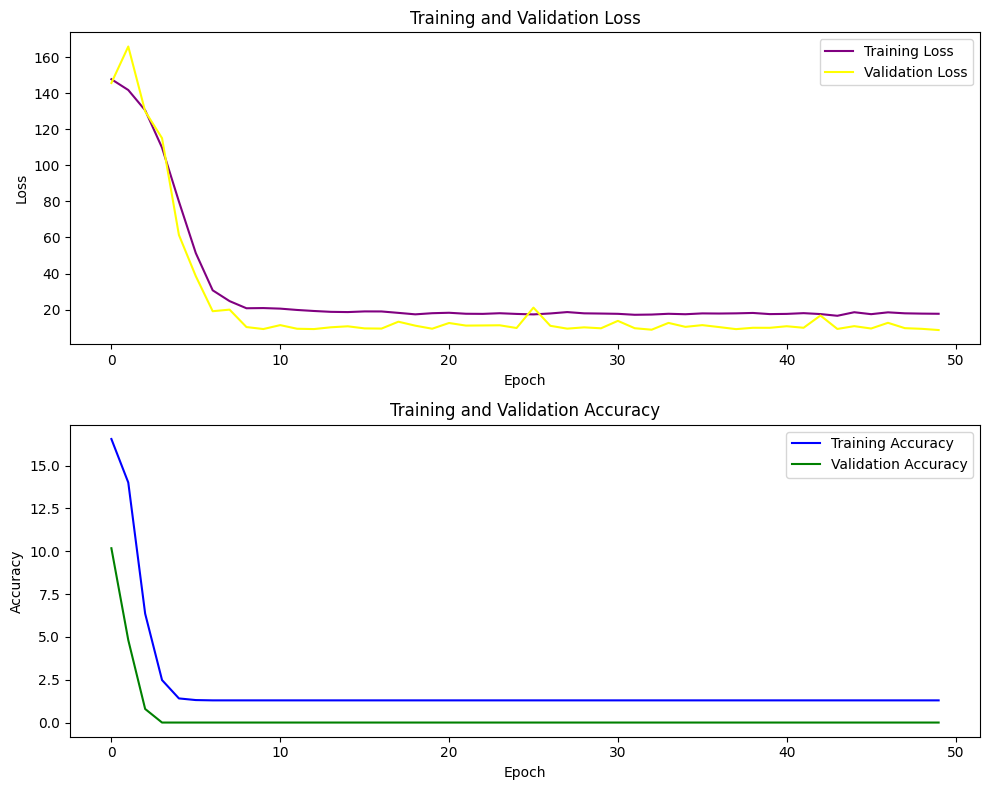

In [38]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot Loss
axs[0].plot(train_losses, label='Training Loss', color='purple')
axs[0].plot(eval_losses, label='Validation Loss', color='Yellow')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()

# Plot Accuracy
axs[1].plot(train_accuracy, label='Training Accuracy', color='blue')
axs[1].plot(val_accuracy, label='Validation Accuracy', color='green')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

### References
1. Dataset: **Student Alcohol Consumption** ([Kaggle Link](https://www.kaggle.com/your-dataset))  
2. Model Tuning: [KerasTuner Documentation](https://keras.io/keras_tuner/)  
3. WANDB Tracking: [WANDB Documentation](https://docs.wandb.ai/)
4. ChatGPT AI tool: [ChatGPT](https://chatgpt.com/)
5. Luthando Maqondo: AI & Machine Learning @CORTEXHUB